# 基于高斯模型的彩色图像反向投影

   图像反向投影的最终目的是获取ROI然后实现对ROI区域的标注、识别、测量等图像处理与分析，是计算机视觉与人工智能的常见方法之一。图像反向投影通常是彩色图像投影效果会比灰度图像效果要好，原因在于彩色图像带有更多对象细节信息，在反向投影的时候更加容易判断、而转为灰度图像会导致这些细节信息丢失、从而导致分割失败。最常见的是基于图像直方图特征的反向投影。我们这里介绍一种跟直方图反向投影不一样的彩色图像反向投影方法，通过基于高斯的概率分布公式（PDF）估算，反向投影得到对象区域，该方法也可以看做最简单的图像分割方法。缺点是对象颜色光照改变和尺度改变不具备不变性特征。所以需要在光照度稳定情况下成像采集图像数据。在这种情况下使用的高斯概率密度公式为： 
    
    ![image.png](attachment:image.png)
    
1. 输入模型M，对M的每个像素点（R,G,B）计算I=R+G+B 
r=R/I, g=G/I, b=B/I 
2. 根据得到权重比例值，计算得到对应的均值 与标准方差 
3. 对输入图像的每个像素点计算根据高斯公式计算P(r)与P(g)的乘积 

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import skimage.io
import imageio

In [96]:
src = imageio.imread('../datas/f3.jpg')
model = imageio.imread('../datas/f3-model.jpg')

In [120]:
def copyTo(img,mask):
    if len(img.shape) == 3 and len(mask.shape) != 3:
        new_image = img * (mask[:,:,None].astype(img.dtype))
    # Case #2 - Both images are colour or grayscale
    elif (len(img.shape) == 3 and len(mask.shape) == 3) or \
       (len(img.shape) == 1 and len(mask.shape) == 1):
        new_image = img * (mask.astype(img.dtype))
    # Otherwise, we can't do this
    else:
        raise Exception("Incompatible input and mask dimensions")
    return new_image

In [112]:
def gaussian_backproject(src,model):
    srcf = np.float32(src)
    modelf = np.float32(model)
    
    modelR = modelf[:,:,0]
    modelG = modelf[:,:,1]
    eps = 1.0e-5
    for i in range(model.shape[0]):
        for j in range(model.shape[1]):
            r = modelf[i,j,0]
            g = modelf[i,j,1]
            b = modelf[i,j,1]
            sum_rgb = r + g + b
            modelR[i,j] = r / (sum_rgb + eps)
            modelG[i,j] = g / (sum_rgb + eps)
    mr = np.mean(modelR)
    devr = np.std(modelR)
    mg = np.mean(modelG)
    devg =np.mean(modelG)
    
    rows,cols = srcf.shape[0],srcf.shape[1]
    backprojection  = np.zeros((rows,cols),dtype=srcf.dtype)
    for i in range(rows):
        for j in range(cols):
            r = srcf[i,j,0]
            g = srcf[i,j,1]
            b = srcf[i,j,2]
            sum_rgb = r + g + b + eps
            red = r / sum_rgb
            green = g / sum_rgb
            pr = (1 / (devr*np.sqrt(2 * np.pi)))*np.exp(-(((red - mr)**2)) / (2 * (devr**2)))
            pg = (1 / (devg*np.sqrt(2 * np.pi)))*np.exp(-(((green - mg)**2)) / (2 * (devg**2)))
            sum_val = pr * pg
            backprojection [i,j] = sum_val
    result = np.zeros_like(srcf)
    result =  srcf * (backprojection [:,:,None].astype(srcf.dtype))
    idx = result > 1.0e-1
    segmentation = np.zeros_like(src)
    segmentation[idx] = src[idx]
    return segmentation,backprojection

In [113]:
segmentation,backprojection = gaussian_backproject(src,model)

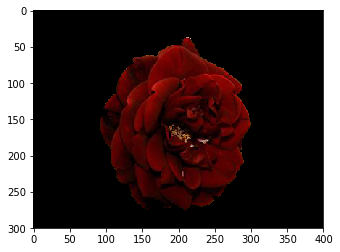

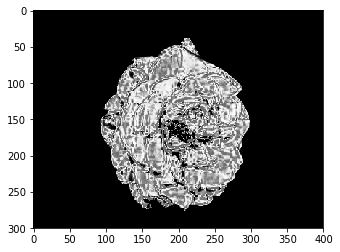

In [115]:
plt.figure()
plt.imshow(segmentation)
plt.figure()
plt.imshow(backprojection,'gray')

In [116]:
src = imageio.imread('../datas/f6.jpg')
model = imageio.imread('../datas/f6-model.jpg')

In [117]:
segmentation,backprojection = gaussian_backproject(src,model)

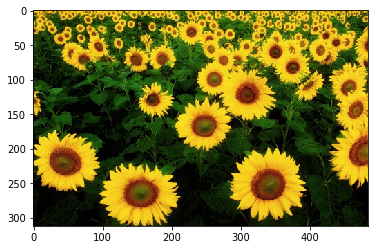

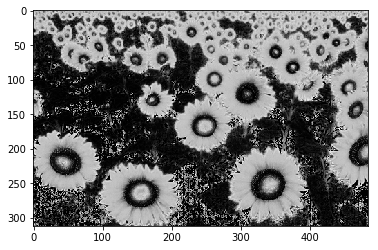

In [118]:
plt.figure()
plt.imshow(segmentation)
plt.figure()
plt.imshow(backprojection,'gray')